In [37]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# 1. 정확한 경로에서 폰트 불러오기
font_path = "C:/Windows/Fonts/malgun.ttf"  # '맑은 고딕' 경로
font_prop = fm.FontProperties(fname=font_path)

# 2. 전체 설정 적용 (폰트 이름 직접 명시)
plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["axes.unicode_minus"] = False
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)



In [57]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# 1. 정확한 폰트 경로
font_path = "C:/Windows/Fonts/malgun.ttf"
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = font_prop.get_name()  # ✅ 핵심
plt.rcParams["axes.unicode_minus"] = False


In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("start_stop_with_exp_change.csv", low_memory=False)

In [4]:
# 문자열이 '미가입'이면 0, 그 외는 1
df["guild_flag"] = (df["character_guild_name"] != "미가입").astype(int)

In [5]:
# 해방 여부: TRUE/FALSE (문자 또는 bool)를 1/0 정수형으로 변환
df["liberation_flag"] = df["liberation_quest_clear_flag"].astype(str).str.upper() == "TRUE"
df["liberation_flag"] = df["liberation_flag"].astype(int)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1793659 entries, 0 to 1793658
Data columns (total 59 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   ocid                         object 
 1   ranking                      float64
 2   character_name               object 
 3   world_name                   object 
 4   character_gender             object 
 5   character_class              object 
 6   character_class_level        float64
 7   character_guild_name         object 
 8   character_date_create        object 
 9   liberation_quest_clear_flag  bool   
 10  character_level_start        float64
 11  character_exp_start          float64
 12  popularity_start             float64
 13  arcane_sum_start             float64
 14  authentic_sum_start          float64
 15  set_absorlab_count_start     int64  
 16  set_lubatiss_count_start     int64  
 17  set_arcane_count_start       int64  
 18  set_eternal_count_start      int64  
 19  

In [7]:
df = pd.read_csv("time_varying_with_all_changes.csv", low_memory=False)

<lifelines.CoxTimeVaryingFitter: fitted with 1793658 periods, 209179 subjects, 20789 events>
         event col = 'event'
number of subjects = 209179
 number of periods = 1793658
  number of events = 20789
partial log-likelihood = -248579.17
  time fit was run = 2025-05-02 00:17:39 UTC

---
                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                              
popularity_change_log -0.47      0.62      0.01           -0.49           -0.45                0.61                0.64
authentic_sum_change  -0.09      0.91      0.00           -0.09           -0.09                0.91                0.92
guild_flag            -0.29      0.75      0.00           -0.30           -0.29                0.74                0.75
liberation_flag       -0.33      0.72      0.01           -0.35           -0.31                0.71                0.73

                       cmp to      z      p  -log2(p)
covariate                                            
popularity_change_log    0.00 -51.42 <0.005       inf
authentic_sum_change     0.00 -43.79 <0.005       inf
guild_flag               0.00 -73.40 <0.005       inf
liberation_flag          0.00 -38.68 <0.005       inf
---
Partial AIC = 497166.33
log-likelihood ratio test = 10073.44 on 4 df
-log2(p) of ll-ratio test = inf

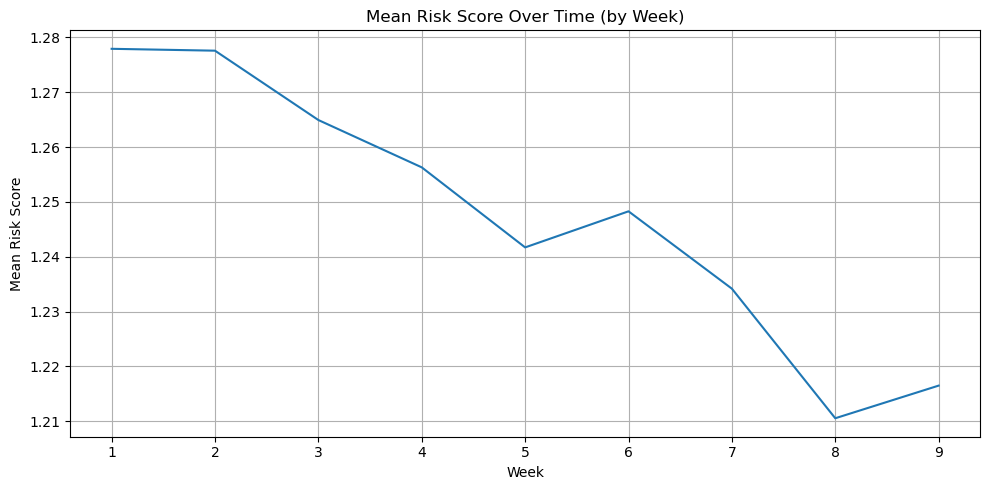

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxTimeVaryingFitter
import numpy as np
from sklearn.preprocessing import StandardScaler
# 1. 데이터 불러오기
df = pd.read_csv("time_varying_with_all_changes.csv", low_memory=False)
# 2. 날짜형 변환 및 기준일 설정
df["start_date"] = pd.to_datetime(df["start_date"])
df["stop_date"] = pd.to_datetime(df["stop_date"])
start_point = df["start_date"].min()
df["start"] = (df["start_date"] - start_point).dt.days
df["stop"] = (df["stop_date"] - start_point).dt.days

# 3. 주차 생성 (정상 주차 흐름 파악용)
df["week"] = ((df["start_date"] - start_point).dt.days // 7) + 1
df = df[df["week"] <= 9]
# 4. 인기도 로그변환
df["popularity_change_log"] = df["popularity_change"].apply(
    lambda x: np.sign(x) * np.log1p(abs(x)) if pd.notnull(x) else 0
)

# 5. 사용할 피처
features_final = [
    "popularity_change_log",
    "authentic_sum_change",
    "guild_flag",
    "liberation_flag"
]

# 6. 안정화 처리
for col in features_final:
    df[col] = df[col].clip(-1000, 1000)

scaler = StandardScaler()
df[features_final] = scaler.fit_transform(df[features_final])

# 7. 최종 데이터 구성
df_cleaned = df[["ocid", "start", "stop", "event", "week"] + features_final].copy()
df_cleaned = df_cleaned.replace([np.inf, -np.inf], np.nan).dropna()

# 8. 모델 학습
ctv = CoxTimeVaryingFitter()
ctv.fit(df_cleaned.drop(columns=["week"]), id_col="ocid", start_col="start", stop_col="stop", event_col="event")
# 결과 출력
ctv.print_summary()
# 9. 위험도 예측
df_cleaned["risk_score"] = ctv.predict_partial_hazard(df_cleaned[features_final])

# 10. 정상 주차 기준 위험도 시계열
risk_by_week = df_cleaned.groupby("week")["risk_score"].mean().reset_index()

# 11. 시각화
plt.figure(figsize=(10, 5))
sns.lineplot(data=risk_by_week, x="week", y="risk_score")
plt.title("Mean Risk Score Over Time (by Week)")
plt.xlabel("Week")
plt.ylabel("Mean Risk Score")
plt.grid(True)
plt.tight_layout()
plt.show()

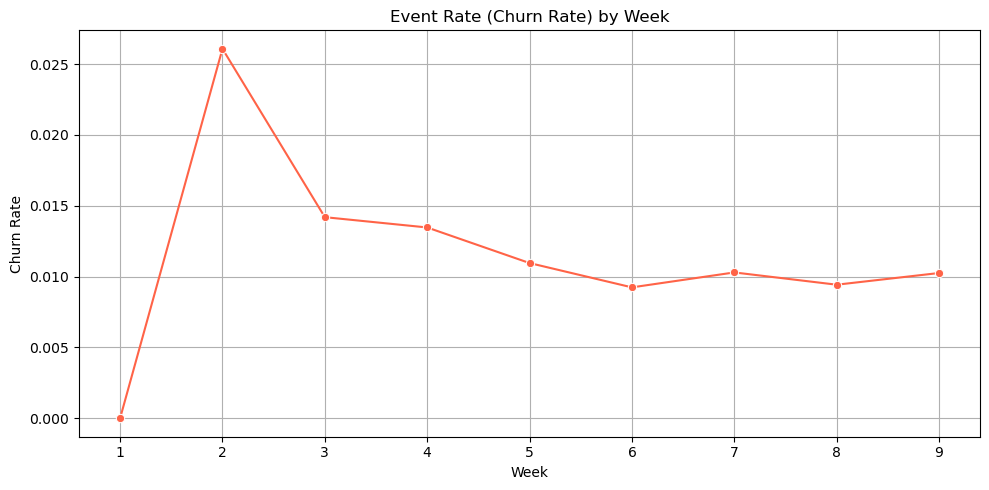

In [14]:
# 주차별 event 발생률 계산
event_by_week = df_cleaned.groupby("week")["event"].agg(["sum", "count"]).reset_index()
event_by_week["event_rate"] = event_by_week["sum"] / event_by_week["count"]

# 시각화: 이탈률
plt.figure(figsize=(10, 5))
sns.lineplot(data=event_by_week, x="week", y="event_rate", marker="o", color="tomato")
plt.title("Event Rate (Churn Rate) by Week")
plt.xlabel("Week")
plt.ylabel("Churn Rate")
plt.grid(True)
plt.tight_layout()
plt.show()




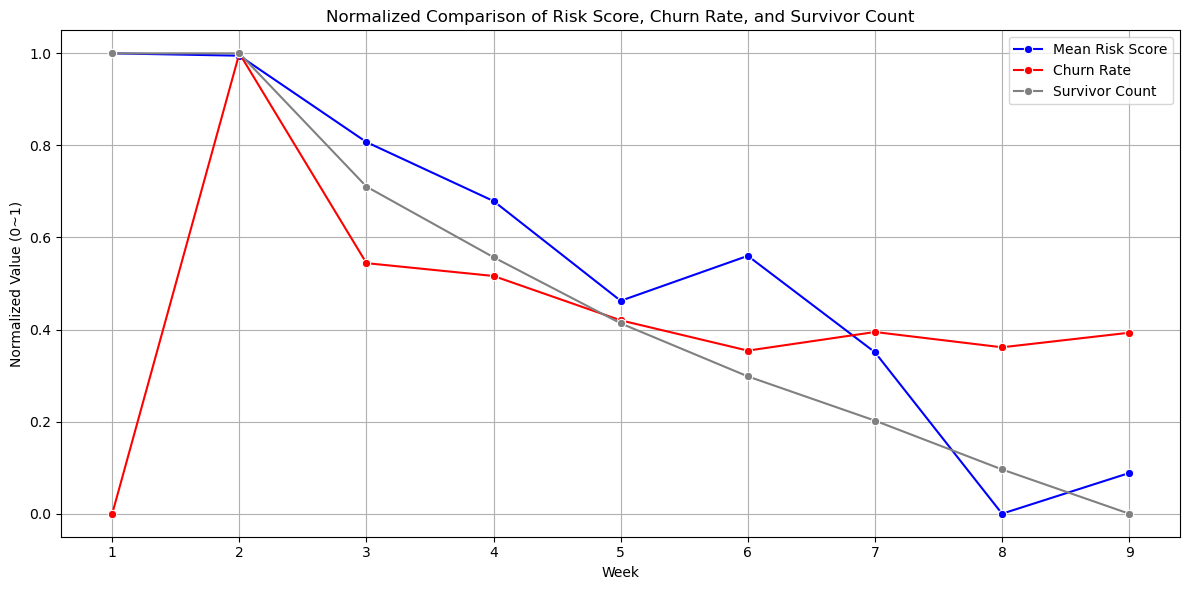

In [20]:
# 1. 주차별 요약: risk_score, churn_rate, survivor_count
summary_by_week = df_cleaned.groupby("week").agg({
    "risk_score": "mean",
    "event": "mean",           # 이탈률
    "ocid": "nunique"          # 생존자 수
}).reset_index()

summary_by_week.columns = ["week", "mean_risk_score", "churn_rate", "survivor_count"]

# 정규화 함수
def normalize(col):
    return (col - col.min()) / (col.max() - col.min())

# 각 컬럼 정규화
summary_norm = summary_by_week.copy()
summary_norm["risk_score_norm"] = normalize(summary_by_week["mean_risk_score"])
summary_norm["churn_rate_norm"] = normalize(summary_by_week["churn_rate"])
summary_norm["survivor_norm"] = normalize(summary_by_week["survivor_count"])

# 시각화
plt.figure(figsize=(12, 6))
sns.lineplot(data=summary_norm, x="week", y="risk_score_norm", label="Mean Risk Score", marker="o", color="blue")
sns.lineplot(data=summary_norm, x="week", y="churn_rate_norm", label="Churn Rate", marker="o", color="red")
sns.lineplot(data=summary_norm, x="week", y="survivor_norm", label="Survivor Count", marker="o", color="gray")

plt.title("Normalized Comparison of Risk Score, Churn Rate, and Survivor Count")
plt.xlabel("Week")
plt.ylabel("Normalized Value (0~1)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
df_cleaned[df_cleaned["week"] == 8][features_final].mean()


popularity_change_log    0.008294
authentic_sum_change     0.055344
guild_flag               0.007836
liberation_flag          0.063030
dtype: float64

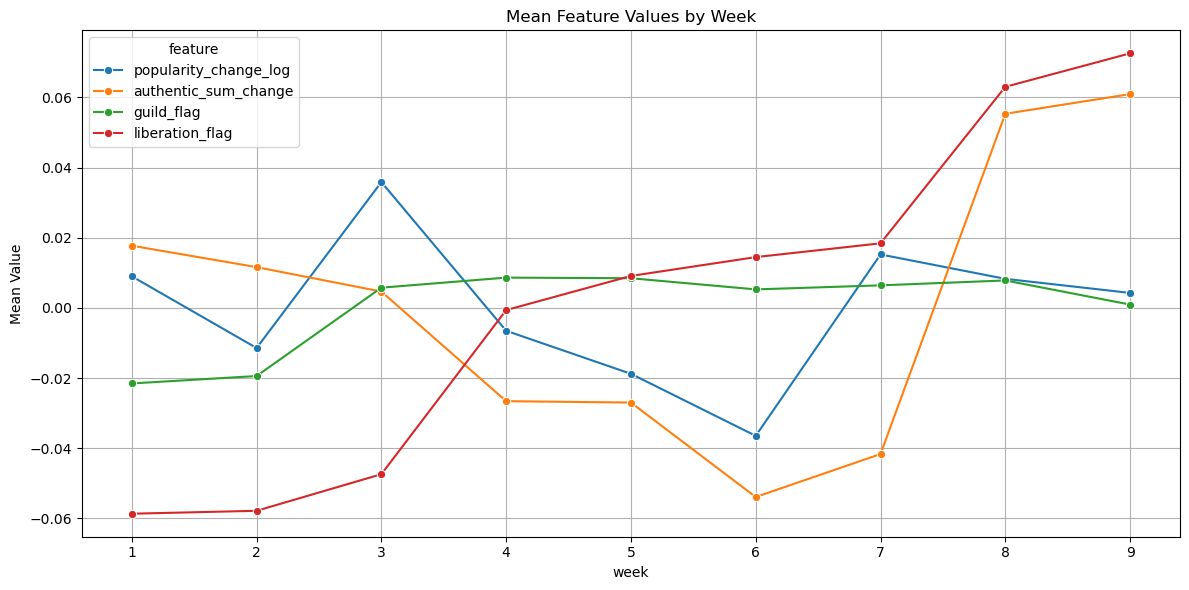

In [17]:
# 주차별 평균 피처 값 계산
feature_means_by_week = df_cleaned.groupby("week")[[
    "popularity_change_log", "authentic_sum_change", "guild_flag", "liberation_flag"
]].mean().reset_index()

import seaborn as sns
import matplotlib.pyplot as plt

# Melt the DataFrame for easier lineplotting
feature_means_melted = feature_means_by_week.melt(id_vars="week", var_name="feature", value_name="mean_value")

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=feature_means_melted, x="week", y="mean_value", hue="feature", marker="o")
plt.title("Mean Feature Values by Week")
plt.ylabel("Mean Value")
plt.grid(True)
plt.tight_layout()
plt.show()


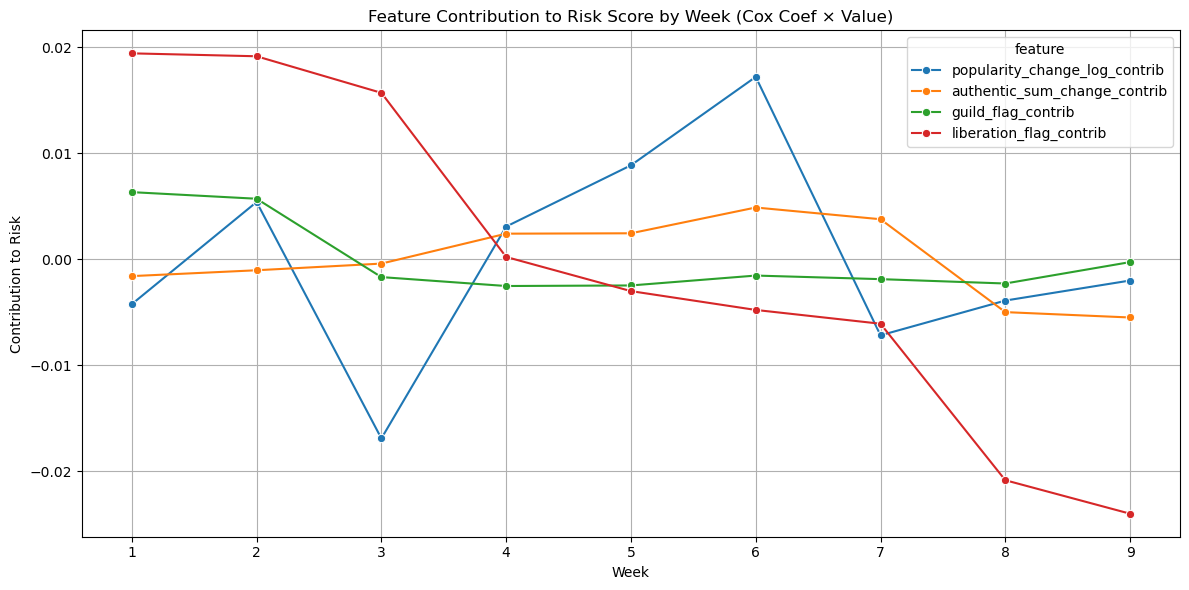

In [18]:
# 📌 피처 기여도 계산: coef * 해당 주차 피처 값
contrib_df = df_cleaned.copy()
for col in features_final:
    contrib_df[f"{col}_contrib"] = ctv.params_[col] * contrib_df[col]

# 📊 주차별 평균 기여도 계산
contrib_summary = contrib_df.groupby("week")[
    [f"{col}_contrib" for col in features_final]
].mean().reset_index()

# 📈 시각화: 주차별 기여도 변화 (lineplot 형태)
contrib_melted = contrib_summary.melt(id_vars="week", var_name="feature", value_name="contribution")

plt.figure(figsize=(12, 6))
sns.lineplot(data=contrib_melted, x="week", y="contribution", hue="feature", marker="o")
plt.title("Feature Contribution to Risk Score by Week (Cox Coef × Value)")
plt.xlabel("Week")
plt.ylabel("Contribution to Risk")
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
ocid_target = "2f70c853829c5d4538e7acb25e07d6c3"

# ocid 포함 여부 확인
print("✅ 포함 여부:", ocid_target in df_cleaned["ocid"].values)

# 해당 ocid의 데이터 출력
df_cleaned[df_cleaned["ocid"] == ocid_target]


✅ 포함 여부: True


,ocid,start,stop,event,week,popularity_change_log,authentic_sum_change,guild_flag,liberation_flag,risk_score
332039,2f70c853829c5d4538e7acb25e07d6c3,0,7,0,1,0.961211,0.829847,0.240965,-0.795234,0.714942
332040,2f70c853829c5d4538e7acb25e07d6c3,7,14,0,2,-0.264914,1.891457,0.240965,-0.795234,1.157659
332041,2f70c853829c5d4538e7acb25e07d6c3,14,21,0,3,-0.264914,-0.231764,0.240965,-0.795234,1.402326
332042,2f70c853829c5d4538e7acb25e07d6c3,21,28,0,4,-0.264914,-0.231764,0.240965,-0.795234,1.402326
332043,2f70c853829c5d4538e7acb25e07d6c3,28,35,0,5,-0.264914,-0.231764,0.240965,-0.795234,1.402326
332044,2f70c853829c5d4538e7acb25e07d6c3,35,42,0,6,-0.264914,-0.231764,0.240965,-0.795234,1.402326
332045,2f70c853829c5d4538e7acb25e07d6c3,42,49,0,7,0.961211,-0.231764,0.240965,-0.795234,0.786873
332046,2f70c853829c5d4538e7acb25e07d6c3,49,56,0,8,-0.264914,-0.231764,0.240965,1.257492,0.711143
332047,2f70c853829c5d4538e7acb25e07d6c3,56,63,0,9,0.961211,-0.231764,0.240965,1.257492,0.399037


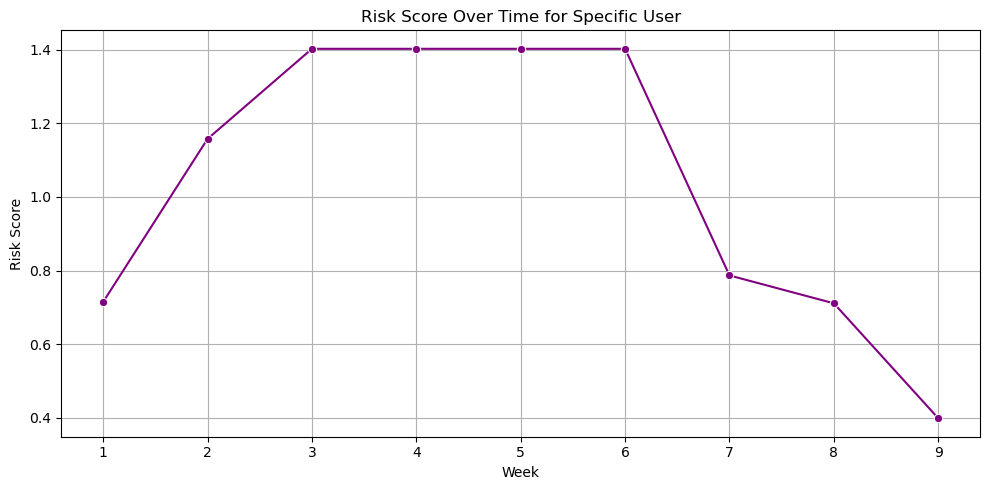

In [24]:
ocid_target = "2f70c853829c5d4538e7acb25e07d6c3"
user_df = df_cleaned[df_cleaned["ocid"] == ocid_target]

plt.figure(figsize=(10, 5))
sns.lineplot(data=user_df, x="week", y="risk_score", marker="o", color="purple")
plt.title("Risk Score Over Time for Specific User")
plt.xlabel("Week")
plt.ylabel("Risk Score")
plt.grid(True)
plt.tight_layout()
plt.show()


In [31]:
# 유저 데이터
ocid_target = "2f70c853829c5d4538e7acb25e07d6c3"
user_df = df_cleaned[df_cleaned["ocid"] == ocid_target].copy()

# 모델 계수
coefs = ctv.params_[features_final]

# 주차별 기여도 계산 + risk_score 포함
rows = []
for _, row in user_df.iterrows():
    week = row["week"]
    risk_score = row["risk_score"]
    contrib = row[features_final] * coefs
    contrib["week"] = week
    contrib["risk_score"] = risk_score
    rows.append(contrib)

# 결과 DataFrame
contrib_df = pd.DataFrame(rows)
contrib_df = contrib_df[["week", "risk_score"] + features_final]
contrib_df = contrib_df.sort_values("week").reset_index(drop=True)






In [51]:
# 타겟 ocid
ocid_target = "2f70c853829c5d4538e7acb25e07d6c3"

# 필요한 컬럼만 선택
cols = ["week", "start", "stop", "event", 
        "character_guild_name", "liberation_quest_clear_flag", 
        "popularity_change", "authentic_sum_change","authentic_sum_start","authentic_sum_stop" ]

# 필터링
user_info = df[df["ocid"] == ocid_target][cols].sort_values("week").reset_index(drop=True)

In [52]:
user_info 

,week,start,stop,event,character_guild_name,liberation_quest_clear_flag,popularity_change,authentic_sum_change,authentic_sum_start,authentic_sum_stop
0,1,0,7,0,화원,False,1.0,0.829847,25.0,26.0
1,2,7,14,0,화원,False,0.0,1.891457,26.0,28.0
2,3,14,21,0,화원,False,0.0,-0.231764,28.0,28.0
3,4,21,28,0,화원,False,0.0,-0.231764,28.0,28.0
4,5,28,35,0,화원,False,0.0,-0.231764,28.0,28.0
5,6,35,42,0,화원,False,0.0,-0.231764,28.0,28.0
6,7,42,49,0,화원,False,1.0,-0.231764,28.0,28.0
7,8,49,56,0,화원,True,0.0,-0.231764,28.0,28.0
8,9,56,63,0,화원,True,1.0,-0.231764,28.0,28.0


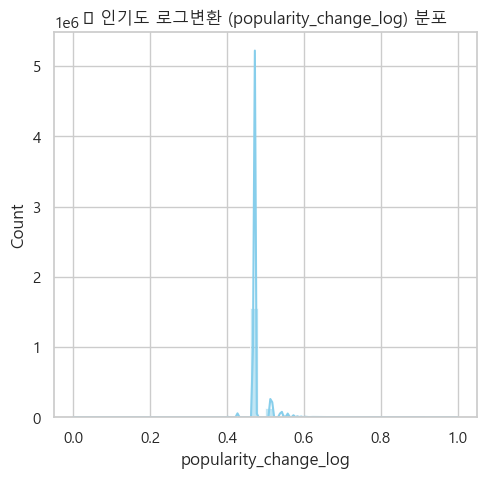

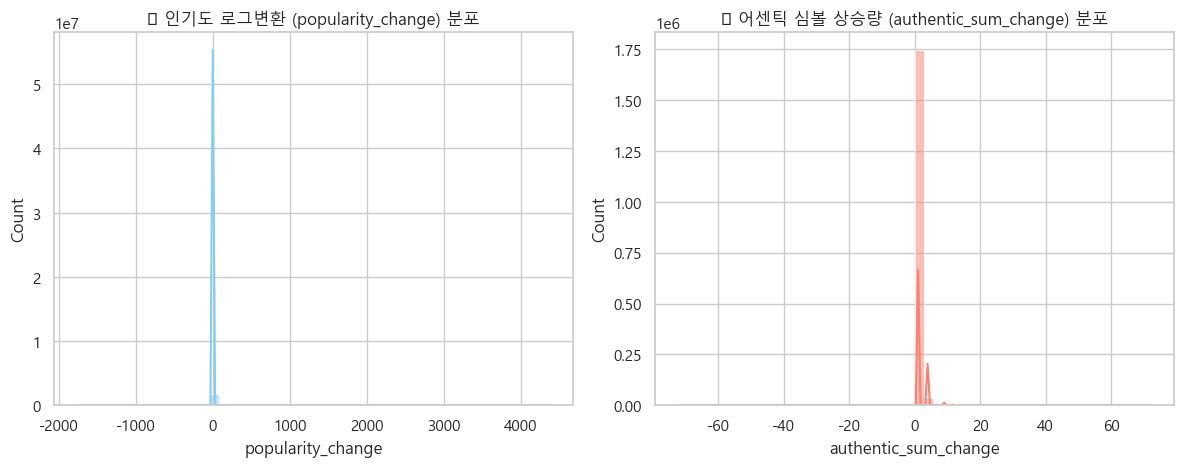

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 인기도 로그변환 분포
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_cleaned["popularity_change_log"], kde=True, bins=50, color="skyblue")
plt.title("📊 인기도 로그변환 (popularity_change_log) 분포")
plt.xlabel("popularity_change_log")

# 1. 인기도 로그변환 분포
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df["popularity_change"], kde=True, bins=50, color="skyblue")
plt.title("📊 인기도 변화 (popularity_change) 분포")
plt.xlabel("popularity_change")
# 2. 심볼 상승량 분포
plt.subplot(1, 2, 2)
sns.histplot(df_cleaned["authentic_sum_change"], kde=True, bins=50, color="salmon")
plt.title("📊 어센틱 심볼 상승량 (authentic_sum_change) 분포")
plt.xlabel("authentic_sum_change")

plt.tight_layout()
plt.show()


In [70]:
print("길드 플래그 값 분포:")
print(df_cleaned["guild_flag"].value_counts())

print("\n해방 플래그 값 분포:")
print(df_cleaned["liberation_flag"].value_counts())


길드 플래그 값 분포:
guild_flag
1    1695226
0      98432
Name: count, dtype: int64

해방 플래그 값 분포:
liberation_flag
0    1098788
1     694870
Name: count, dtype: int64


In [77]:
# 제로 vs 일반 직업 인기도 변화량 요약 통계 비교
zero_stats = df[df["is_zero"] == True]["popularity_change"].describe()
normal_stats = df[df["is_zero"] == False]["popularity_change"].describe()

# 두 결과를 하나의 DataFrame으로 정리
comparison_df = pd.DataFrame({
    "제로": zero_stats,
    "일반 직업": normal_stats
})
comparison_df

,제로,일반 직업
count,42473.000000,1.751185e+06
mean,2.186118,1.304673e+00
std,55.176193,1.535485e+01
min,-24.000000,-1.752000e+03
25%,0.000000,0.000000e+00
50%,0.000000,0.000000e+00
75%,0.000000,0.000000e+00
max,4368.000000,2.332000e+03


<lifelines.CoxTimeVaryingFitter: fitted with 1793658 periods, 209179 subjects, 20789 events>
         event col = 'event'
number of subjects = 209179
 number of periods = 1793658
  number of events = 20789
partial log-likelihood = -248579.17
  time fit was run = 2025-05-02 02:26:12 UTC

---
                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                              
popularity_log_zscore -0.47      0.62      0.01           -0.49           -0.45                0.61                0.64
authentic_sum_change  -0.10      0.91      0.00           -0.10           -0.09                0.90                0.91
guild_flag            -1.29      0.28      0.02           -1.32           -1.25                0.27                0.29
liberation_flag       -0.68      0.51      0.02           -0.71           -0.64                0.49                0.52

                       cmp to      z      p  -log2(p)
covariate                                            
popularity_log_zscore    0.00 -51.42 <0.005       inf
authentic_sum_change     0.00 -43.79 <0.005       inf
guild_flag               0.00 -73.40 <0.005       inf
liberation_flag          0.00 -38.68 <0.005       inf
---
Partial AIC = 497166.33
log-likelihood ratio test = 10073.44 on 4 df
-log2(p) of ll-ratio test = inf

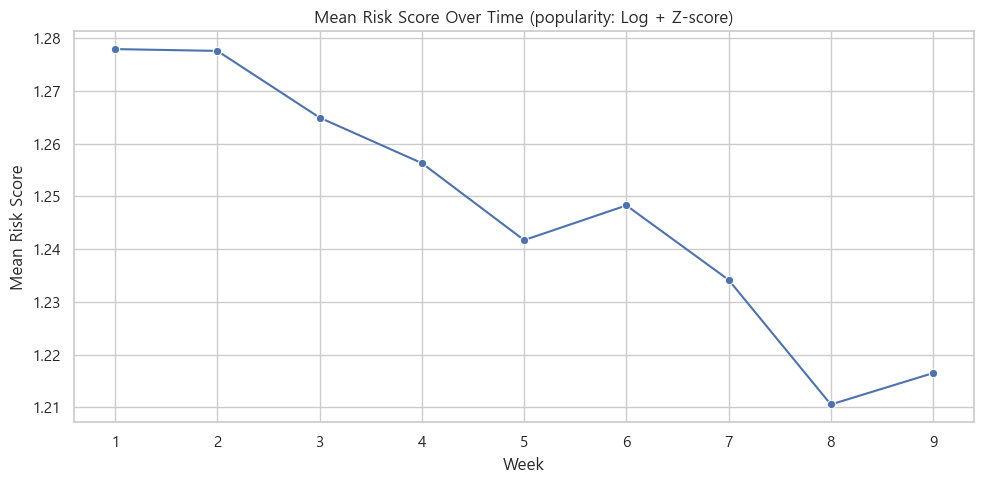

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxTimeVaryingFitter
import numpy as np

# 1. 데이터 불러오기
df = pd.read_csv("time_varying_with_all_changes.csv", low_memory=False)

# 2. 날짜형 변환 및 기준일 설정
df["start_date"] = pd.to_datetime(df["start_date"])
df["stop_date"] = pd.to_datetime(df["stop_date"])
start_point = df["start_date"].min()
df["start"] = (df["start_date"] - start_point).dt.days
df["stop"] = (df["stop_date"] - start_point).dt.days

# 3. 주차 생성
df["week"] = ((df["start_date"] - start_point).dt.days // 7) + 1
df = df[df["week"] <= 9]

# 4. 인기도: 로그변환 + Z-score 정규화
df["popularity_log"] = df["popularity_change"].apply(
    lambda x: np.sign(x) * np.log1p(abs(x)) if pd.notnull(x) else 0
)

mean_val = df["popularity_log"].mean()
std_val = df["popularity_log"].std()
df["popularity_log_zscore"] = (df["popularity_log"] - mean_val) / std_val

# 5. 사용할 피처
features_final = [
    "popularity_log_zscore",     
    "authentic_sum_change",
    "guild_flag",
    "liberation_flag"
]

# 6. 극단값 클리핑만 유지
for col in features_final:
    df[col] = df[col].clip(-1000, 1000)

# 7. 최종 데이터 구성
df_cleaned = df[["ocid", "start", "stop", "event", "week"] + features_final].copy()
df_cleaned = df_cleaned.replace([np.inf, -np.inf], np.nan).dropna()

# 8. 모델 학습
ctv = CoxTimeVaryingFitter()
ctv.fit(df_cleaned.drop(columns=["week"]), id_col="ocid", start_col="start", stop_col="stop", event_col="event")

# 9. 요약 출력
ctv.print_summary()

# 10. 위험도 예측
df_cleaned["risk_score"] = ctv.predict_partial_hazard(df_cleaned[features_final])

# 11. 주차별 평균 위험도 시각화
risk_by_week = df_cleaned.groupby("week")["risk_score"].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=risk_by_week, x="week", y="risk_score", marker="o")
plt.title("Mean Risk Score Over Time (popularity: Log + Z-score)")
plt.xlabel("Week")
plt.ylabel("Mean Risk Score")
plt.grid(True)
plt.tight_layout()
plt.show()


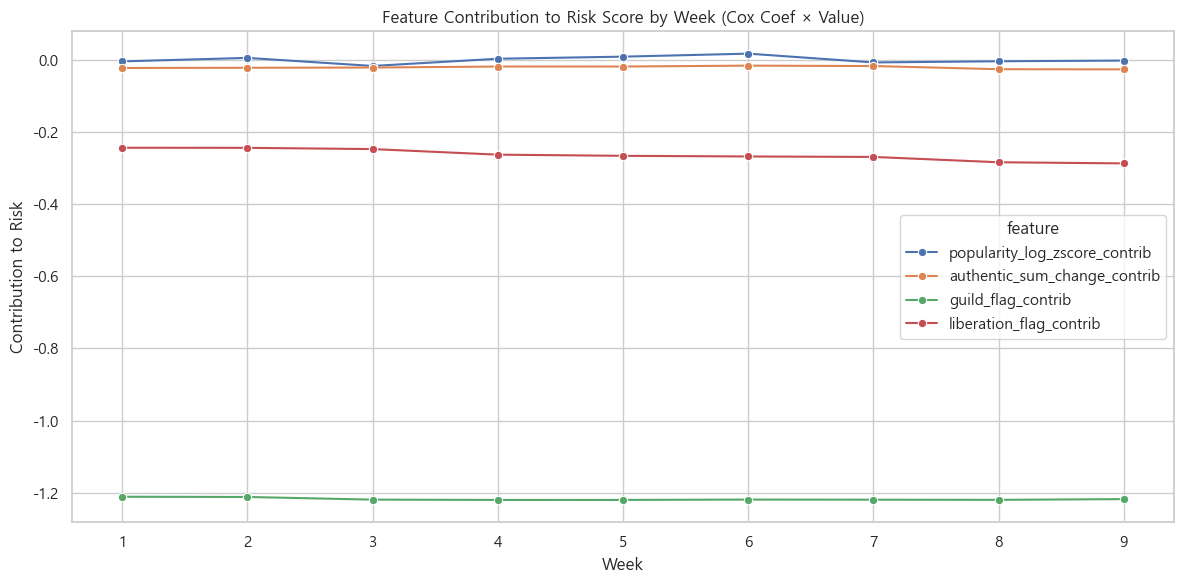

In [79]:
# 피처 기여도 계산: coef * 해당 주차 피처 값
contrib_df = df_cleaned.copy()
for col in features_final:
    contrib_df[f"{col}_contrib"] = ctv.params_[col] * contrib_df[col]

#  주차별 평균 기여도 계산
contrib_summary = contrib_df.groupby("week")[
    [f"{col}_contrib" for col in features_final]
].mean().reset_index()

#  시각화: 주차별 기여도 변화 (lineplot 형태)
contrib_melted = contrib_summary.melt(id_vars="week", var_name="feature", value_name="contribution")

plt.figure(figsize=(12, 6))
sns.lineplot(data=contrib_melted, x="week", y="contribution", hue="feature", marker="o")
plt.title("Feature Contribution to Risk Score by Week (Cox Coef × Value)")
plt.xlabel("Week")
plt.ylabel("Contribution to Risk")
plt.grid(True)
plt.tight_layout()
plt.show()


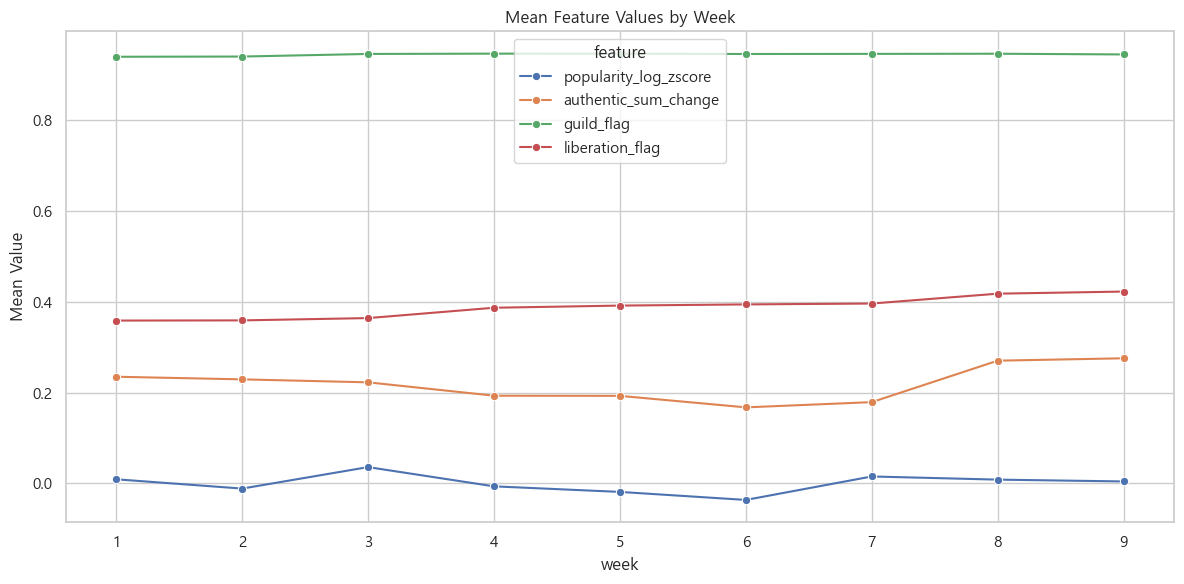

In [81]:
# 주차별 평균 피처 값 계산
feature_means_by_week = df_cleaned.groupby("week")[[
    "popularity_log_zscore", "authentic_sum_change", "guild_flag", "liberation_flag"
]].mean().reset_index()

import seaborn as sns
import matplotlib.pyplot as plt

# Melt the DataFrame for easier lineplotting
feature_means_melted = feature_means_by_week.melt(id_vars="week", var_name="feature", value_name="mean_value")

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=feature_means_melted, x="week", y="mean_value", hue="feature", marker="o")
plt.title("Mean Feature Values by Week")
plt.ylabel("Mean Value")
plt.grid(True)
plt.tight_layout()
plt.show()


In [82]:
# 타겟 ocid
ocid_target = "2f70c853829c5d4538e7acb25e07d6c3"

# 필요한 컬럼만 선택
cols = ["week", "start", "stop", "event", 
        "character_guild_name", "liberation_quest_clear_flag", 
        "popularity_change", "authentic_sum_change","authentic_sum_start","authentic_sum_stop" ]

# 필터링
user_info = df[df["ocid"] == ocid_target][cols].sort_values("week").reset_index(drop=True)

In [83]:
user_info 

,week,start,stop,event,character_guild_name,liberation_quest_clear_flag,popularity_change,authentic_sum_change,authentic_sum_start,authentic_sum_stop
0,1,0,7,0,화원,False,1.0,1.0,25.0,26.0
1,2,7,14,0,화원,False,0.0,2.0,26.0,28.0
2,3,14,21,0,화원,False,0.0,0.0,28.0,28.0
3,4,21,28,0,화원,False,0.0,0.0,28.0,28.0
4,5,28,35,0,화원,False,0.0,0.0,28.0,28.0
5,6,35,42,0,화원,False,0.0,0.0,28.0,28.0
6,7,42,49,0,화원,False,1.0,0.0,28.0,28.0
7,8,49,56,0,화원,True,0.0,0.0,28.0,28.0
8,9,56,63,0,화원,True,1.0,0.0,28.0,28.0


In [93]:
from scipy.stats import zscore

# 1. 유저 ID 설정
target_ocid = "2f70c853829c5d4538e7acb25e07d6c3"

# 2. 유저 데이터 불러오기
user_info = df[df["ocid"] == target_ocid].copy()

# 3. popularity 로그 변환 후 z-score 계산
user_info["popularity_log"] = user_info["popularity_change"].apply(lambda x: np.sign(x) * np.log1p(abs(x)) if pd.notnull(x) else 0)
user_info["popularity_log_zscore"] = zscore(user_info["popularity_log"])

# 4. Cox 계수 가져오기
coefs = dict(ctv.params_)

# 5. 각 피처별 기여도 계산
for col in features_final:
    user_info[col + "_contrib"] = user_info[col] * coefs[col]

# 6. Risk Score 계산
user_info["risk_score"] = sum(user_info[col + "_contrib"] for col in features_final)

# 7. 확인할 컬럼만 정리
cols_to_show = [
    "week", "popularity_change", "popularity_log", "popularity_log_zscore",
    "authentic_sum_change", "guild_flag", "liberation_flag",
] + [col + "_contrib" for col in features_final] + ["risk_score"]

user_info[cols_to_show]


,week,popularity_change,popularity_log,popularity_log_zscore,authentic_sum_change,guild_flag,liberation_flag,popularity_log_zscore_contrib,authentic_sum_change_contrib,guild_flag_contrib,liberation_flag_contrib,risk_score
332039,1,1.0,0.693147,1.414214,1.0,1,0,-0.666458,-0.095866,-1.288165,-0.000000,-2.050490
332040,2,0.0,0.000000,-0.707107,2.0,1,0,0.333229,-0.191732,-1.288165,-0.000000,-1.146668
332041,3,0.0,0.000000,-0.707107,0.0,1,0,0.333229,-0.000000,-1.288165,-0.000000,-0.954936
332042,4,0.0,0.000000,-0.707107,0.0,1,0,0.333229,-0.000000,-1.288165,-0.000000,-0.954936
332043,5,0.0,0.000000,-0.707107,0.0,1,0,0.333229,-0.000000,-1.288165,-0.000000,-0.954936
332044,6,0.0,0.000000,-0.707107,0.0,1,0,0.333229,-0.000000,-1.288165,-0.000000,-0.954936
332045,7,1.0,0.693147,1.414214,0.0,1,0,-0.666458,-0.000000,-1.288165,-0.000000,-1.954624
332046,8,0.0,0.000000,-0.707107,0.0,1,1,0.333229,-0.000000,-1.288165,-0.679013,-1.633949
332047,9,1.0,0.693147,1.414214,0.0,1,1,-0.666458,-0.000000,-1.288165,-0.679013,-2.633637


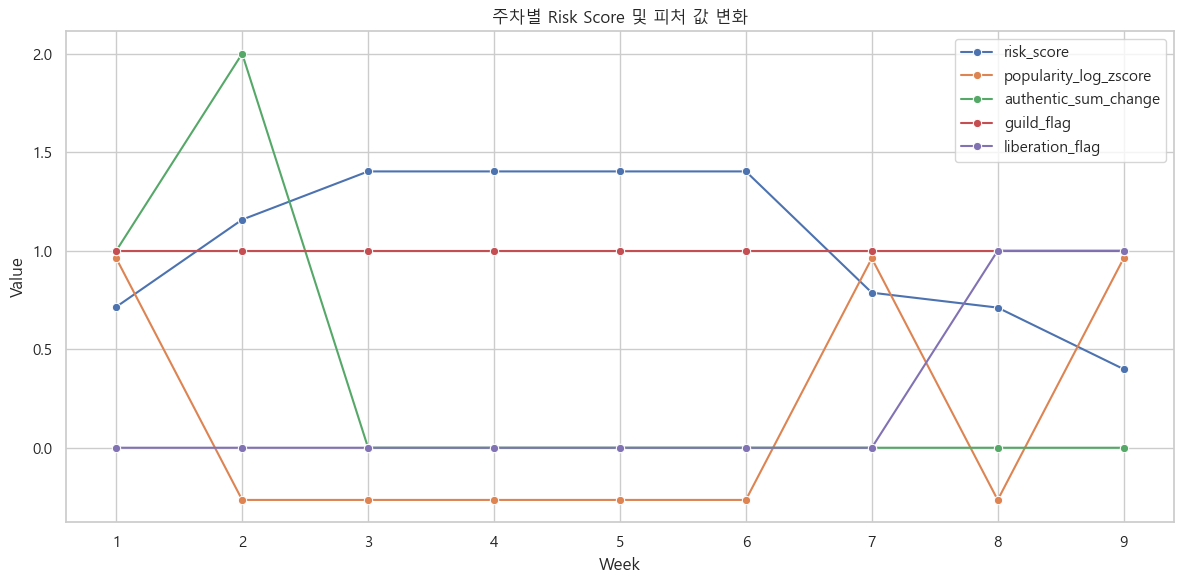

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 그래프용 데이터 준비: df_cleaned와 features_final 가정
features_final = [
    "popularity_log_zscore",
    "authentic_sum_change",
    "guild_flag",
    "liberation_flag"
]

# 유저 ID를 지정 (이전과 동일한 예시)
target_ocid = "2f70c853829c5d4538e7acb25e07d6c3"

# 해당 유저의 데이터만 필터링
user_df = df_cleaned[df_cleaned["ocid"] == target_ocid].copy()

# 그래프 그리기
plt.figure(figsize=(12, 6))

# risk_score 선
sns.lineplot(data=user_df, x="week", y="risk_score", label="risk_score", marker="o")

# 각 피처 그리기
for col in features_final:
    sns.lineplot(data=user_df, x="week", y=col, label=col, marker="o")

plt.title("주차별 Risk Score 및 피처 값 변화")
plt.xlabel("Week")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

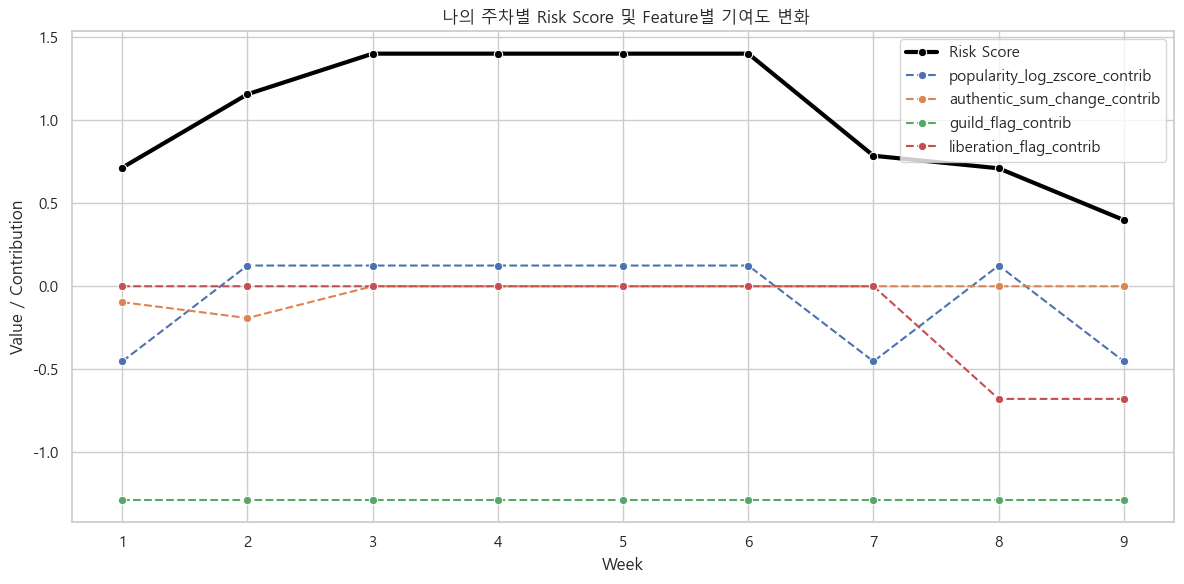

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

# Cox 계수 가져오기
coefs = dict(ctv.params_)

# 유저 ID
target_ocid = "2f70c853829c5d4538e7acb25e07d6c3"

# 해당 유저 데이터
user_df = df_cleaned[df_cleaned["ocid"] == target_ocid].copy()

# 기여도 계산
for col in features_final:
    user_df[col + "_contrib"] = user_df[col] * coefs[col]

# 📈 한 그래프에 함께 시각화
plt.figure(figsize=(12, 6))

# ① Risk Score (굵은 선)
sns.lineplot(data=user_df, x="week", y="risk_score", label="Risk Score", linewidth=3, marker="o", color="black")

# ② 각 Feature 기여도 (얇은 선)
for col in features_final:
    sns.lineplot(data=user_df, x="week", y=col + "_contrib", label=col + "_contrib", marker="o", linestyle="--")

# 🧾 그래프 설정
plt.title(" 나의 주차별 Risk Score 및 Feature별 기여도 변화")
plt.xlabel("Week")
plt.ylabel("Value / Contribution")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


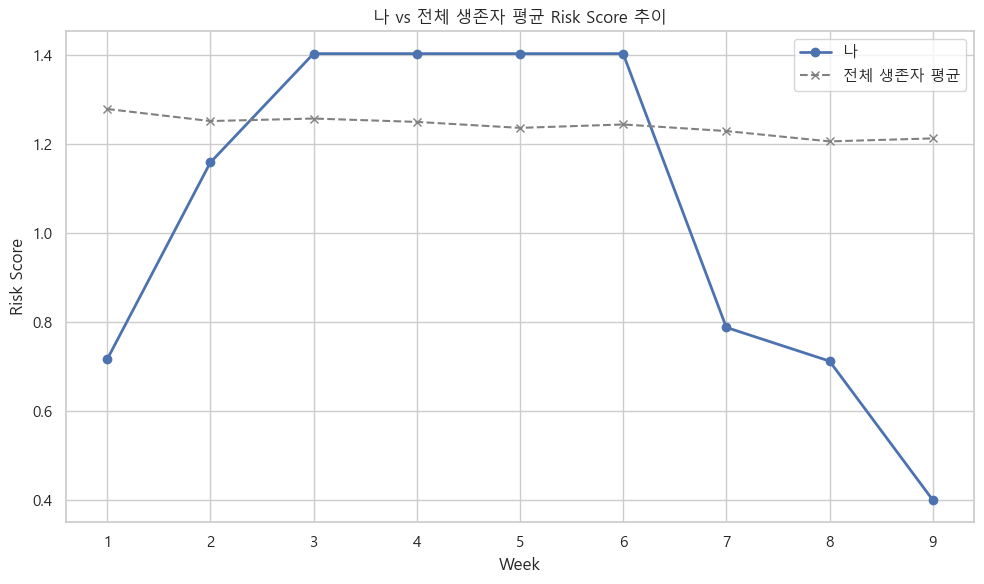

,week,survivor_mean_risk,my_risk
0,1,1.277916,0.714942
1,2,1.250785,1.157659
2,3,1.256449,1.402326
3,4,1.248874,1.402326
4,5,1.235454,1.402326
5,6,1.243146,1.402326
6,7,1.228309,0.786873
7,8,1.205071,0.711143
8,9,1.211763,0.399037


In [68]:
import pandas as pd
import matplotlib.pyplot as plt

#  너의 OCID
your_ocid = "2f70c853829c5d4538e7acb25e07d6c3"

#  너의 risk_score 추이
your_df = df_cleaned[df_cleaned["ocid"] == your_ocid][["week", "risk_score"]].rename(columns={"risk_score": "my_risk"})

#  전체 생존자 평균 risk_score (event == 0)
survivor_mean = (
    df_cleaned[df_cleaned["event"] == 0]
    .groupby("week")["risk_score"]
    .mean()
    .reset_index()
    .rename(columns={"risk_score": "survivor_mean_risk"})
)

#  병합
compare_df = survivor_mean.merge(your_df, on="week", how="left")

#  시각화
plt.figure(figsize=(10, 6))
plt.plot(compare_df["week"], compare_df["my_risk"], label="나", marker="o", linewidth=2)
plt.plot(compare_df["week"], compare_df["survivor_mean_risk"], label="전체 생존자 평균", marker="x", linestyle="--", color="gray")

plt.title("나 vs 전체 생존자 평균 Risk Score 추이")
plt.xlabel("Week")
plt.ylabel("Risk Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#  숫자로도 확인하고 싶다면
compare_df


In [104]:
# 시간 상호작용 항 추가
for col in features_final:
    df_cleaned[f"{col}_x_time"] = df_cleaned[col] * df_cleaned["stop"]

# 다시 학습
features_with_interaction = features_final + [f"{col}_x_time" for col in features_final]

ctv = CoxTimeVaryingFitter()
ctv.fit(df_cleaned[["ocid", "start", "stop", "event"] + features_with_interaction], 
        id_col="ocid", start_col="start", stop_col="stop", event_col="event")

ctv.print_summary()


<lifelines.CoxTimeVaryingFitter: fitted with 1793658 periods, 209179 subjects, 20789 events>
         event col = 'event'
number of subjects = 209179
 number of periods = 1793658
  number of events = 20789
partial log-likelihood = -248438.65
  time fit was run = 2025-05-02 05:07:30 UTC

---
                              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                     
popularity_log_zscore        -0.39      0.68      0.02           -0.43           -0.35                0.65                0.71
authentic_sum_change         -0.09      0.92      0.01           -0.10           -0.07                0.91                0.93
guild_flag                   -1.77      0.17      0.04           -1.85           -1.70                0.16                0.18
liberation_flag              -0.87      0.42      0.04           -0.95           -0.79                0.39                0.46
popularity_log_zscore_x_time -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
authentic_sum_change_x_time  -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
guild_flag_x_time             0.02      1.02      0.00            0.01            0.02                1.01                1.02
liberation_flag_x_time        0.01      1.01      0.00            0.00            0.01                1.00                1.01

                              cmp to      z      p  -log2(p)
covariate                                                   
popularity_log_zscore           0.00 -18.00 <0.005    238.22
authentic_sum_change            0.00 -13.94 <0.005    144.38
guild_flag                      0.00 -46.95 <0.005       inf
liberation_flag                 0.00 -21.41 <0.005    335.28
popularity_log_zscore_x_time    0.00  -4.15 <0.005     14.86
authentic_sum_change_x_time     0.00  -1.69   0.09      3.45
guild_flag_x_time               0.00  13.92 <0.005    143.97
liberation_flag_x_time          0.00   5.10 <0.005     21.51
---
Partial AIC = 496893.31
log-likelihood ratio test = 10354.46 on 8 df
-log2(p) of ll-ratio test = inf

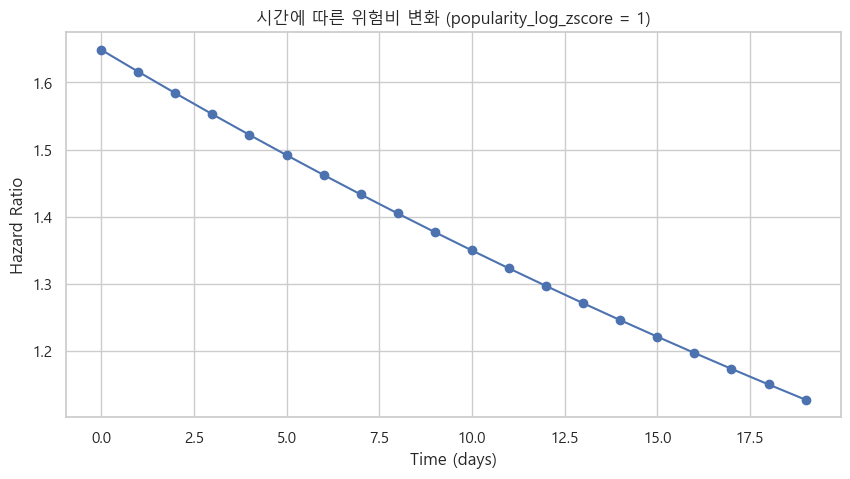

In [105]:
import matplotlib.pyplot as plt
import numpy as np

x = 1  # 인기도가 1 증가한 유저
t_range = np.arange(0, 20)
hr = np.exp(0.5 * x + (-0.02) * x * t_range)

plt.plot(t_range, hr, marker='o')
plt.title("시간에 따른 위험비 변화 (popularity_log_zscore = 1)")
plt.xlabel("Time (days)")
plt.ylabel("Hazard Ratio")
plt.grid(True)
plt.show()


In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxTimeVaryingFitter

# 1. 데이터 로드 및 전처리
df = pd.read_csv("time_varying_with_all_changes.csv")

# 날짜 → 일수 변환
df["start_date"] = pd.to_datetime(df["start_date"])
df["stop_date"] = pd.to_datetime(df["stop_date"])
start_point = df["start_date"].min()
df["start"] = (df["start_date"] - start_point).dt.days
df["stop"] = (df["stop_date"] - start_point).dt.days

# 로그변환 + Z-score
df["popularity_log"] = df["popularity_change"].apply(lambda x: np.sign(x) * np.log1p(abs(x)) if pd.notnull(x) else 0)
mean_val = df["popularity_log"].mean()
std_val = df["popularity_log"].std()
df["popularity_log_zscore"] = (df["popularity_log"] - mean_val) / std_val

# 사용할 변수
features = [
    "popularity_log_zscore",     
    "authentic_sum_change",
    "guild_flag",
    "liberation_flag"
]

# 시간-상호작용 항 추가
for col in features:
    df[f"{col}_x_time"] = df[col] * df["stop"]

# 학습용 데이터 구성
cols_for_model = ["ocid", "start", "stop", "event"] + features + [f"{col}_x_time" for col in features]
df_cleaned = df[cols_for_model].replace([np.inf, -np.inf], np.nan).dropna()

# Cox 모델 학습
ctv = CoxTimeVaryingFitter()
ctv.fit(df_cleaned, id_col="ocid", start_col="start", stop_col="stop", event_col="event")
ctv.print_summary()


<lifelines.CoxTimeVaryingFitter: fitted with 1793659 periods, 209179 subjects, 20789 events>
         event col = 'event'
number of subjects = 209179
 number of periods = 1793659
  number of events = 20789
partial log-likelihood = -248438.65
  time fit was run = 2025-05-02 05:19:07 UTC

---
                              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                     
popularity_log_zscore        -0.39      0.68      0.02           -0.43           -0.35                0.65                0.71
authentic_sum_change         -0.09      0.92      0.01           -0.10           -0.07                0.91                0.93
guild_flag                   -1.77      0.17      0.04           -1.85           -1.70                0.16                0.18
liberation_flag              -0.87      0.42      0.04           -0.95           -0.79                0.39                0.46
popularity_log_zscore_x_time -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
authentic_sum_change_x_time  -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
guild_flag_x_time             0.02      1.02      0.00            0.01            0.02                1.01                1.02
liberation_flag_x_time        0.01      1.01      0.00            0.00            0.01                1.00                1.01

                              cmp to      z      p  -log2(p)
covariate                                                   
popularity_log_zscore           0.00 -18.00 <0.005    238.22
authentic_sum_change            0.00 -13.94 <0.005    144.38
guild_flag                      0.00 -46.95 <0.005       inf
liberation_flag                 0.00 -21.41 <0.005    335.28
popularity_log_zscore_x_time    0.00  -4.15 <0.005     14.86
authentic_sum_change_x_time     0.00  -1.69   0.09      3.45
guild_flag_x_time               0.00  13.92 <0.005    143.97
liberation_flag_x_time          0.00   5.10 <0.005     21.51
---
Partial AIC = 496893.31
log-likelihood ratio test = 10354.46 on 8 df
-log2(p) of ll-ratio test = inf

In [107]:
# 대상 유저
target_ocid = "2f70c853829c5d4538e7acb25e07d6c3"
user_df = df_cleaned[df_cleaned["ocid"] == target_ocid].copy()

# 위험스코어 계산
user_df["risk_score"] = ctv.predict_partial_hazard(user_df)


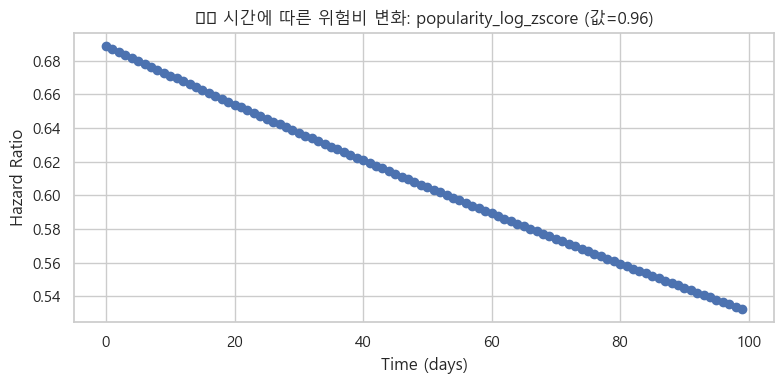

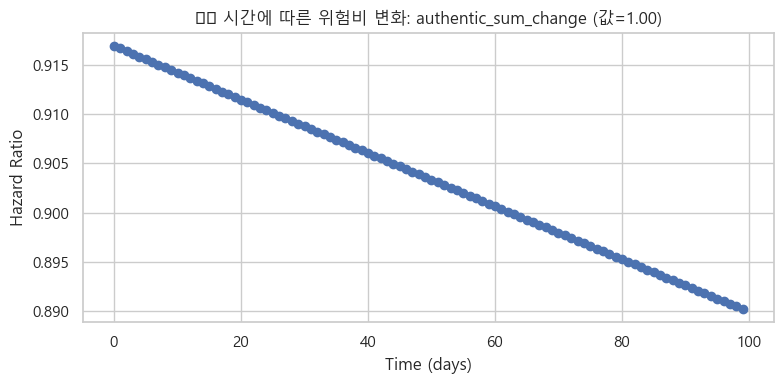

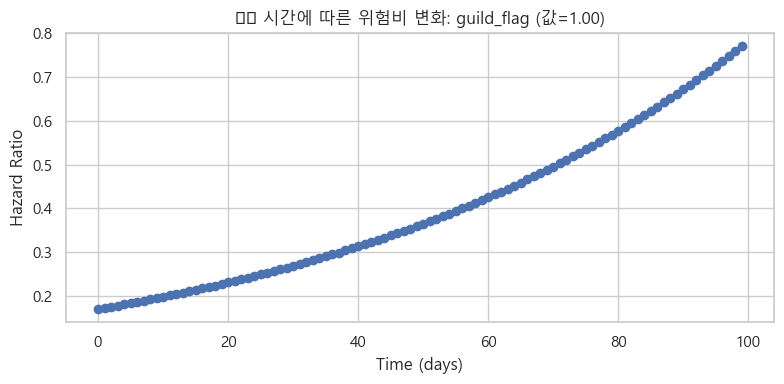

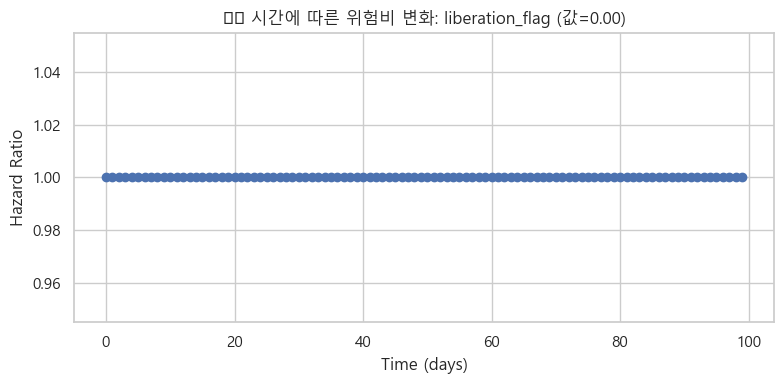

In [109]:
target_ocid = "2f70c853829c5d4538e7acb25e07d6c3"
user_df = df_cleaned[df_cleaned["ocid"] == target_ocid].copy()

features = [
    "popularity_log_zscore",     
    "authentic_sum_change",
    "guild_flag",
    "liberation_flag"
]

plot_time_dependent_hazard(user_df, ctv, features)


In [108]:
import numpy as np
import matplotlib.pyplot as plt

def plot_time_dependent_hazard(user_df, model, features, t_range=100):
    """
    시간에 따라 위험비(Hazard Ratio)가 어떻게 변하는지 변수별로 시각화
    
    Parameters:
    - user_df: 단일 유저에 대한 데이터 (DataFrame)
    - model: 학습된 CoxTimeVaryingFitter 객체
    - features: 시간-상호작용 항을 포함한 주요 변수 리스트
    - t_range: 시간 범위 (days)
    """
    t = np.arange(0, t_range)

    for col in features:
        # 해당 유저의 값
        x = user_df[col].iloc[0]
        
        # coef + 시간항이 없으면 건너뜀
        coef_name = col
        coef_time_name = f"{col}_x_time"
        if coef_name not in model.params_ or coef_time_name not in model.params_:
            continue
        
        coef = model.params_[coef_name]
        coef_time = model.params_[coef_time_name]

        # 시간에 따른 HR 계산
        hr = np.exp(coef * x + coef_time * x * t)

        # 시각화
        plt.figure(figsize=(8, 4))
        plt.plot(t, hr, marker="o")
        plt.title(f"⏱️ 시간에 따른 위험비 변화: {col} (값={x:.2f})")
        plt.xlabel("Time (days)")
        plt.ylabel("Hazard Ratio")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [111]:
print(f" 유저 {target_ocid[:6]}... 의 최신 위험 스코어 분석:")
latest = user_df.sort_values("stop", ascending=False).iloc[0]

for col in features:
    val = latest[col]
    coef = ctv.params_[col]
    contrib = coef * val
    print(f" - {col:25}: {val:>6.2f} × {coef:>6.2f} = {contrib:>6.2f}")


🔍 유저 2f70c8... 의 최신 위험 스코어 분석:
 - popularity_log_zscore    :   0.96 ×  -0.39 =  -0.37
 - authentic_sum_change     :   0.00 ×  -0.09 =  -0.00
 - guild_flag               :   1.00 ×  -1.77 =  -1.77
 - liberation_flag          :   1.00 ×  -0.87 =  -0.87


In [113]:
# 필수: df_cleaned에는 모든 유저의 start~stop 주차별 데이터가 있어야 함
df_cleaned["risk_score"] = ctv.predict_partial_hazard(df_cleaned)


In [114]:
# 최신 stop 기준으로 정렬 후 groupby로 최신 row 추출
latest_risk_df = df_cleaned.sort_values(["ocid", "stop"], ascending=[True, False]) \
                            .groupby("ocid", as_index=False).first()


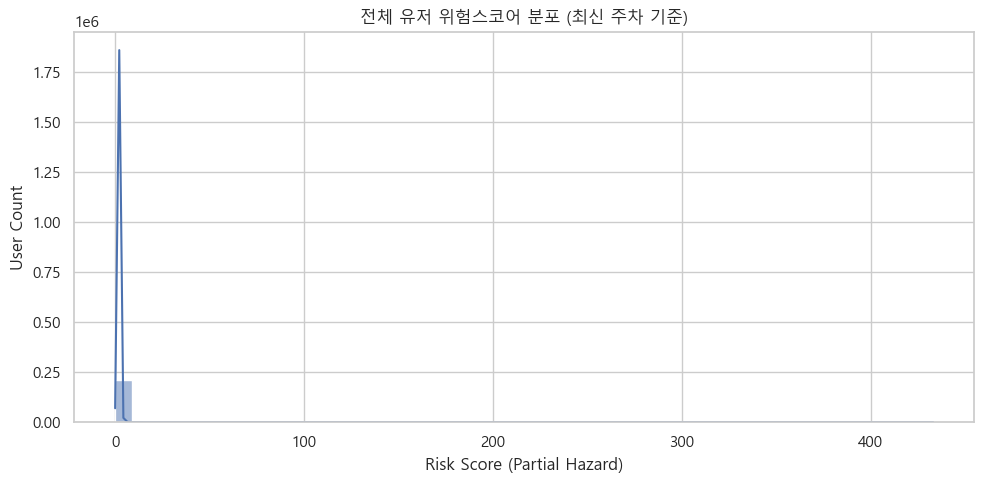

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(latest_risk_df["risk_score"], bins=50, kde=True)
plt.title("전체 유저 위험스코어 분포 (최신 주차 기준)")
plt.xlabel("Risk Score (Partial Hazard)")
plt.ylabel("User Count")
plt.grid(True)
plt.tight_layout()
plt.show()


In [116]:
# 상위 5% 위험 유저
top_risk = latest_risk_df.sort_values("risk_score", ascending=False).head(10)

# 하위 5% 안정 유저
low_risk = latest_risk_df.sort_values("risk_score", ascending=True).head(10)

# 위험스코어 + 변수 기여도 확인
top_risk = top_risk[["ocid", "risk_score", "popularity_log_zscore", "authentic_sum_change", "guild_flag", "liberation_flag"]]
low_risk = low_risk[["ocid", "risk_score", "popularity_log_zscore", "authentic_sum_change", "guild_flag", "liberation_flag"]]


In [129]:
import pandas as pd

# 학습된 모델(ctv)과 df_cleaned가 이미 있다고 가정
# 위험스코어 계산
df_cleaned["risk_score"] = ctv.predict_partial_hazard(df_cleaned)

# 유저별 최신 row만 추출
latest_df = df_cleaned.sort_values(["ocid", "stop"], ascending=[True, False]).groupby("ocid", as_index=False).first()

# 상위/하위 1~2명 샘플링
top_risk_users = latest_df.sort_values("risk_score", ascending=False).head(2)
low_risk_users = latest_df.sort_values("risk_score", ascending=True).head(2)

# 주요 변수
features = ["popularity_log_zscore", "authentic_sum_change", "guild_flag", "liberation_flag"]

# 해석 리포트 생성 함수
def generate_report(row, model, features):
    lines = []
    lines.append(f" 유저 {row['ocid'][:6]}... | Risk Score: {row['risk_score']:.4f}")
    lines.append(" 위험 기여도 분석:")
    total_log_risk = 0
    stop_time = row["stop"]
    for col in features:
        base = row[col]
        time_term = row[col] * stop_time
        coef = model.params_[col]
        coef_time = model.params_[f"{col}_x_time"]
        contrib = coef * base + coef_time * time_term
        total_log_risk += contrib
        lines.append(f" - {col:25}: {base:>6.2f} × {coef:>6.2f} + time × {coef_time:>6.3f} → 기여도 {contrib:>6.2f}")
    lines.append(f" 전체 log 위험도: {total_log_risk:.4f} → exp = {np.exp(total_log_risk):.4f}")
    return "\n".join(lines)
# 예시: 상위 위험 유저 해석 리포트 출력
for report in top_reports:
    print(report)
    print("\n" + "-" * 80 + "\n")

# 하위 위험 유저도 마찬가지
for report in low_reports:
    print(report)
    print("\n" + "-" * 80 + "\n")



🧍 유저 ab23f6... | Risk Score: 432.9145
📊 위험 기여도 분석:
 - popularity_log_zscore    :  -0.26 ×  -0.39 + time × -0.003 → 기여도   0.15
 - authentic_sum_change     : -55.00 ×  -0.09 + time × -0.000 → 기여도   5.80
 - guild_flag               :   1.00 ×  -1.77 + time ×  0.015 → 기여도  -0.81
 - liberation_flag          :   1.00 ×  -0.87 + time ×  0.005 → 기여도  -0.53
📌 전체 log 위험도: 4.6090 → exp = 100.3792

--------------------------------------------------------------------------------

🧍 유저 b3c60d... | Risk Score: 206.8008
📊 위험 기여도 분석:
 - popularity_log_zscore    :  -0.26 ×  -0.39 + time × -0.003 → 기여도   0.15
 - authentic_sum_change     : -48.00 ×  -0.09 + time × -0.000 → 기여도   5.07
 - guild_flag               :   1.00 ×  -1.77 + time ×  0.015 → 기여도  -0.81
 - liberation_flag          :   1.00 ×  -0.87 + time ×  0.005 → 기여도  -0.53
📌 전체 log 위험도: 3.8702 → exp = 47.9506

--------------------------------------------------------------------------------

🧍 유저 7501ce... | Risk Score: 0.0007
📊 위험 기여도 분석:
 - popul

In [122]:
target_ocid = "2f70c853829c5d4538e7acb25e07d6c3"
user_df = df_cleaned[df_cleaned["ocid"] == target_ocid].copy()
user_df["risk_score"] = ctv.predict_partial_hazard(user_df)


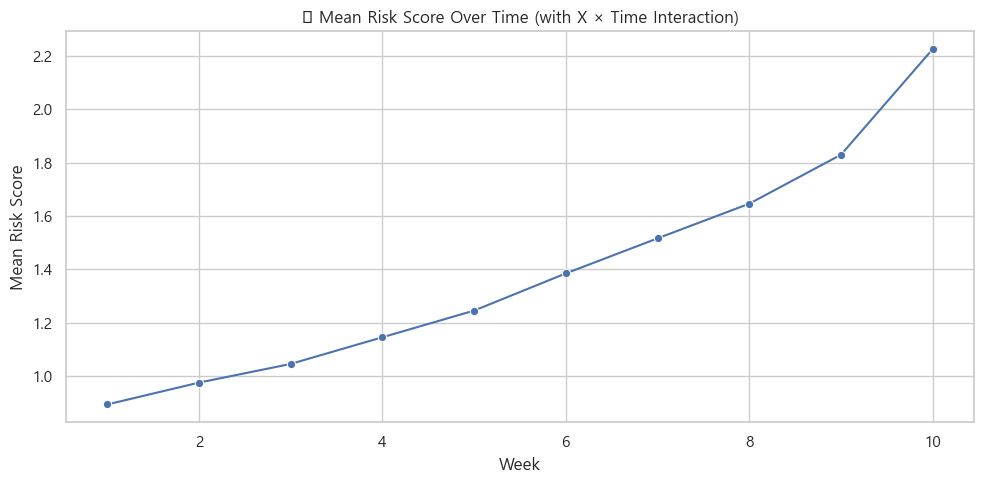

In [132]:
# 시간-상호작용 항 추가한 상태에서 공선성 위험 변수 제거한 후 학습

# 1. 시간 상호작용 항 추가
features = ["popularity_log_zscore", "authentic_sum_change", "guild_flag", "liberation_flag"]
df_extended = df_cleaned.copy()

for col in features:
    df_extended[f"{col}_x_time"] = df_extended[col] * df_extended["stop"]

# 2. 공선성 위험이 있는 상수 변수 찾기
all_vars = features + [f"{col}_x_time" for col in features]
unique_counts = df_extended[all_vars].nunique()

# 3. 상수 변수 제거
drop_cols = unique_counts[unique_counts <= 1].index.tolist()
df_model = df_extended.drop(columns=drop_cols)

# 4. 모델 학습
ctv_clean = CoxTimeVaryingFitter()
ctv_clean.fit(df_model.drop(columns=["week"]), id_col="ocid", start_col="start", stop_col="stop", event_col="event")

# 5. 위험도 예측
remaining_features = [col for col in df_model.columns if col not in ["ocid", "start", "stop", "event", "week"]]
df_model["risk_score"] = ctv_clean.predict_partial_hazard(df_model[remaining_features])

# 6. 주차별 평균 위험도 시각화
risk_by_week = df_model.groupby("week")["risk_score"].mean().reset_index()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.lineplot(data=risk_by_week, x="week", y="risk_score", marker="o")
plt.title("📉 Mean Risk Score Over Time (with X × Time Interaction)")
plt.xlabel("Week")
plt.ylabel("Mean Risk Score")
plt.grid(True)
plt.tight_layout()
plt.show()


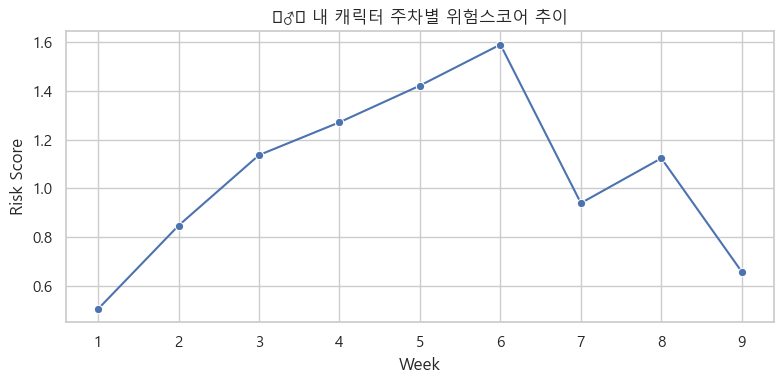

In [134]:
# 너의 OCID 지정
my_ocid = "2f70c853829c5d4538e7acb25e07d6c3"

# 해당 유저만 필터링
my_df = df_model[df_model["ocid"] == my_ocid].copy()

# 주차별 위험스코어 추이 시각화
plt.figure(figsize=(8, 4))
sns.lineplot(data=my_df, x="week", y="risk_score", marker="o")
plt.title("🧍‍♂️ 내 캐릭터 주차별 위험스코어 추이")
plt.xlabel("Week")
plt.ylabel("Risk Score")
plt.grid(True)
plt.tight_layout()
plt.show()


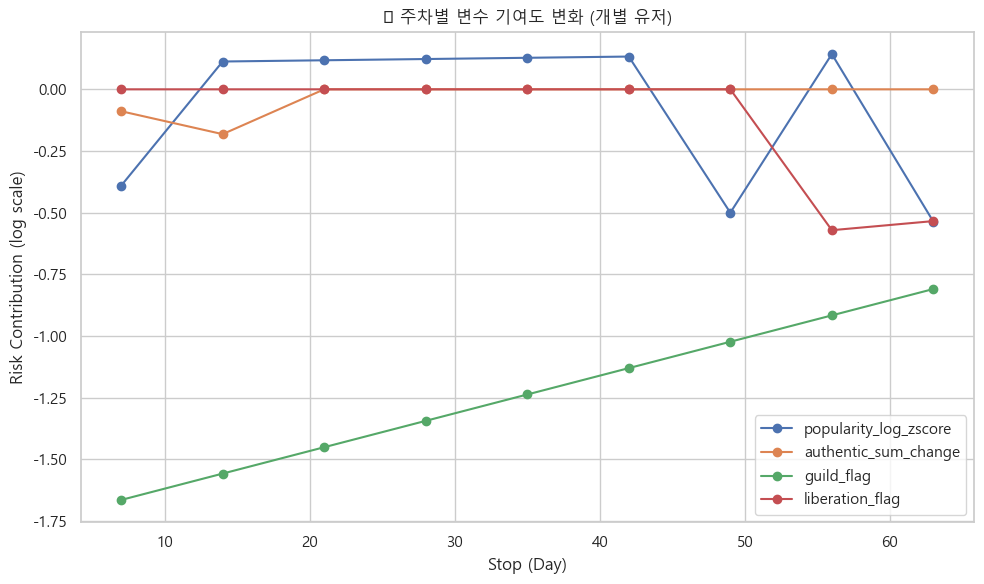

'🧍 유저 2f70c8... | 최신 Risk Score: 0.6579\n📊 변수별 위험 기여도:\n - popularity_log_zscore    :   0.96 ×  -0.39 + time × -0.003 →  -0.54\n - authentic_sum_change     :   0.00 ×  -0.09 + time × -0.000 →  -0.00\n - guild_flag               :   1.00 ×  -1.77 + time ×  0.015 →  -0.81\n - liberation_flag          :   1.00 ×  -0.87 + time ×  0.005 →  -0.53\n📌 총 log 위험도: -1.8802 → exp = 0.1526'

In [136]:
# 대상 유저 OCID
target_ocid = "2f70c853829c5d4538e7acb25e07d6c3"

# 해당 유저 데이터 필터링
user_df = df_model[df_model["ocid"] == target_ocid].copy()

# 변수 목록 (시간항 포함)
features = ["popularity_log_zscore", "authentic_sum_change", "guild_flag", "liberation_flag"]

# 변수별 기여도 계산
for col in features:
    coef = ctv_clean.params_[col]
    coef_time = ctv_clean.params_[f"{col}_x_time"]
    user_df[f"{col}_contrib"] = user_df[col] * coef + user_df["stop"] * user_df[col] * coef_time

# 시각화: 변수별 기여도 변화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for col in features:
    plt.plot(user_df["stop"], user_df[f"{col}_contrib"], marker='o', label=col)
plt.title("🧠 주차별 변수 기여도 변화 (개별 유저)")
plt.xlabel("Stop (Day)")
plt.ylabel("Risk Contribution (log scale)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 최신 주차 해석 리포트 생성
latest = user_df.sort_values("stop").iloc[-1]
lines = [f"🧍 유저 {latest['ocid'][:6]}... | 최신 Risk Score: {latest['risk_score']:.4f}",
         f"📊 변수별 위험 기여도:"]
total_log_risk = 0
for col in features:
    val = latest[col]
    stop = latest["stop"]
    coef = ctv_clean.params_[col]
    coef_time = ctv_clean.params_[f"{col}_x_time"]
    contrib = val * coef + val * stop * coef_time
    total_log_risk += contrib
    lines.append(f" - {col:25}: {val:>6.2f} × {coef:>6.2f} + time × {coef_time:>6.3f} → {contrib:>6.2f}")
lines.append(f"📌 총 log 위험도: {total_log_risk:.4f} → exp = {np.exp(total_log_risk):.4f}")
report = "\n".join(lines)

report
